# Geometric Brownian Motion Demo

Larysa Matiukha and Sou-Cheng T. Choi

Illinois Institute of Technology

Modification date: 06/25/2025

Creation date: 08/24/2024

In [1]:
import qmcpy as qp
import numpy as np
import scipy.stats as sc
from matplotlib import pyplot
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

Geometric Brownian motion (GBM) is a continuous stochastic process in which the natural logarithm of its values follows a Brownian motion. $[1]$

Mathematically, it can be defined as follows:

$\large{S_t = S_0 \, e^{\big(\mu - \frac{\sigma^2}{2}\big)  t + \sigma W_t}}$, 

where
* $S_0$ is the initial value, 
* $\mu$ is a drift coefficient
* $\sigma$ is difussion coefficient  
* $W_t$ is a (standard) Brownian motion.

GBM is commonly used to model stock prices and options payoffs. 

## GBM object in QMCPy

Geometric Brownian Motion in QMCPy inherits from BrownianMotion class $[2, 3]$. 

Let's explore the constructor and sample generation methods through the built-in help documentation:

In [2]:
help(qp.GeometricBrownianMotion.__init__)

Help on function __init__ in module qmcpy.true_measure.geometric_brownian_motion:

__init__(self, sampler, t_final=1, initial_value=1, drift=0, diffusion=1, decomp_type='PCA')
    GeometricBrownianMotion(t) = initial_value * exp[(drift - 0.5 * diffusion) * t
                                                     + \sqrt{diffusion} * StandardBrownianMotion(t)]
    
    Args:
        sampler (DiscreteDistribution/TrueMeasure): A discrete distribution or true measure.
        t_final (float): End time for the geometric Brownian motion, non-negative.
        initial_value (float): Positive initial value of the process.
        drift (float): Drift coefficient.
        diffusion (float): Diffusion coefficient, positive.
        decomp_type (str): Method of decomposition, either "PCA" or "Cholesky".



In [3]:
help(qp.GeometricBrownianMotion.gen_samples)

Help on function gen_samples in module qmcpy.true_measure._true_measure:

gen_samples(self, *args, **kwargs)
    Generate samples from the discrete distribution
    and transform them via the transform method. 
    
    Args:
        args (tuple): positional arguments to the discrete distributions gen_samples method
        kwargs (dict): keyword arguments to the discrete distributions gen_samples method
    
    Returns: 
        ndarray: n x d matrix of transformed samples



Now let's create a simple GBM instance and generate sample paths to see the class in action:

In [4]:
gbm = qp.GeometricBrownianMotion(qp.Lattice(2)) 
gbm

GeometricBrownianMotion (TrueMeasure Object)
    time_vec        [0.5 1. ]
    drift           0
    diffusion       1
    mean_gbm        [1. 1.]
    covariance_gbm  [[0.649 0.649]
                    [0.649 1.718]]
    decomp_type     PCA

In [5]:
gbm.gen_samples(n=4) # generates four 2-dimensional samples

array([[0.53151349, 0.5038797 ],
       [2.14347681, 1.54428853],
       [0.99281531, 0.80700491],
       [0.21376923, 0.29075682]])

### Log-Normality Property

At any time $t > 0$, $S_t$ follows a log-normal distribution with expected value and variance as follows (see Section 3.2 in $[1]$):

- $E[S_t] = S_0 e^{\mu t}$
- $\text{Var}[S_t] = S_0^2 e^{2\mu t}(e^{\sigma^2 t} - 1)$

Let's validate these theoretical properties by generating a large number of GBM samples and comparing the empirical moments with the theoretical values:

In [6]:
# Generate GBM samples for theoretical validation
S0, mu, sigma, T, n_samples = 100.0, 0.05, 0.20, 1.0, 2**12
sampler = qp.Lattice(5, seed=42)
qp_gbm = qp.GeometricBrownianMotion(sampler, t_final=T, initial_value=S0, drift=mu, diffusion=sigma)
paths = qp_gbm.gen_samples(n_samples)
S_T = paths[:, -1]  # Final values only

# Calculate theoretical vs empirical sample moments
theo_mean = S0 * np.exp(mu * T)
theo_var = S0**2 * np.exp(2*mu*T) * (np.exp(sigma**2 * T) - 1)
qp_emp_mean = np.mean(S_T)
qp_emp_var = np.var(S_T, ddof=1) 
print(f"Mean: {qp_emp_mean:.3f} (theoretical: {theo_mean:.3f})")
print(f"Variance: {qp_emp_var:.3f} (theoretical: {theo_var:.3f})")
qp_gbm

Mean: 105.134 (theoretical: 105.127)
Variance: 453.062 (theoretical: 451.029)


GeometricBrownianMotion (TrueMeasure Object)
    time_vec        [0.2 0.4 0.6 0.8 1. ]
    drift           0.050
    diffusion       0.200
    mean_gbm        [101.005 102.02  103.045 104.081 105.127]
    covariance_gbm  [[ 81.943  82.767  83.599  84.439  85.288]
                    [ 82.767 167.869 169.556 171.26  172.981]
                    [ 83.599 169.556 257.923 260.516 263.134]
                    [ 84.439 171.26  260.516 352.258 355.798]
                    [ 85.288 172.981 263.134 355.798 451.029]]
    decomp_type     PCA

## GMB vs Brownian motion

Below we compare Brownian motion and geometric Brownian motion using the same parameters: `drift` = 0, `diffusion` = 1, `initial_value` = 1.

Paths of the Brownian motion should fluctuate symmetrically around the initial value (y = 1) and can take negative values, while those of Geometric Brownian Motion remain strictly positive.

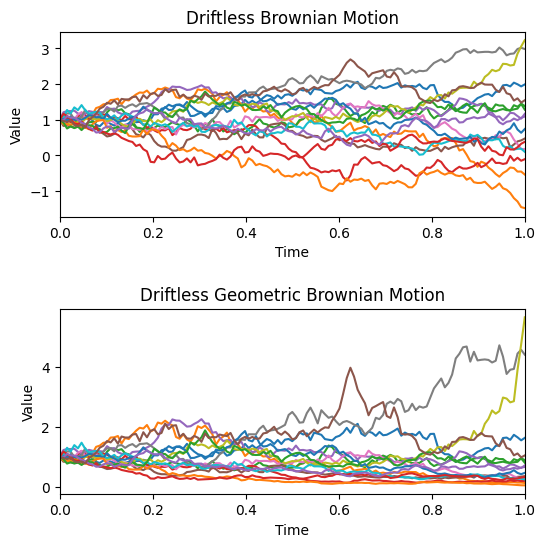

In [7]:
n = 16
discrete_distrib = qp.Lattice(2**7)
geometric_brownian_motions = {
     'Driftless Brownian Motion': qp.BrownianMotion(discrete_distrib,initial_value=1),
     'Driftless Geometric Brownian Motion': qp.GeometricBrownianMotion(discrete_distrib)}
fig,ax = pyplot.subplots(nrows=len(geometric_brownian_motions),
                          ncols=1,figsize=(6,3*len(geometric_brownian_motions)))
ax = np.atleast_1d(ax)
for i,(name,gbm) in enumerate(geometric_brownian_motions.items()):
     t = gbm.gen_samples(n)
     t_w_init = np.hstack([gbm.initial_value*np.ones((n,1)),t])
     tvec_w_0 = np.hstack([0,gbm.time_vec])
     ax[i].plot(tvec_w_0,t_w_init.T)
     ax[i].set_xlim([tvec_w_0[0],tvec_w_0[-1]])
     ax[i].set_title(name)
     ax[i].set_xlabel('Time')  
     ax[i].set_ylabel('Value') 
plt.subplots_adjust(hspace=0.5)
plt.show();

## Generating and Plotting GBM paths

First, let's define a utility function that will help us visualize GBM paths with different samplers and parameters:

In [8]:
def plot_gbm_paths(sampler, t_final, initial_value, drift, diffusion, n):
    gbm = qp.GeometricBrownianMotion(sampler, t_final, initial_value, drift, diffusion)
    t = gbm.gen_samples(n)

    initial_values = np.full((n, 1), gbm.initial_value)
    t_w_init = np.hstack((initial_values, t))
    tvec_w_0 = np.hstack(([0], gbm.time_vec))

    plt.figure(figsize=(7, 4));
    plt.plot(tvec_w_0, t_w_init.T); 
    plt.title(f'Realizations of Geometric Brownian Motion using {type(sampler).__name__} points');
    plt.xlabel('t');
    plt.ylabel('S(t)');
    plt.xlim([tvec_w_0[0], tvec_w_0[-1]]);
    plt.show();

Now, using `plot_gbm_paths`, we generate 32 GBM paths to model stock price, $S(t)$, with initial value $S_0$ = 50, drift coeffient, $\mu = 0.1$, diffusion coefficient $\sigma = 0.2$ using IID points.

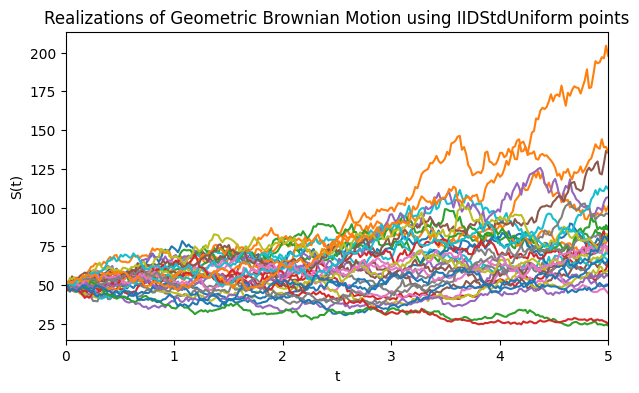

In [9]:
gbm_iid = plot_gbm_paths(qp.IIDStdUniform(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2, n=32)

## GBM Using Low-Discrepancy Lattice Sequence Distrubtion 

Using the same parameter values as in example above, we generate 32 GBM paths to model stock price using low-discrepancy lattice points

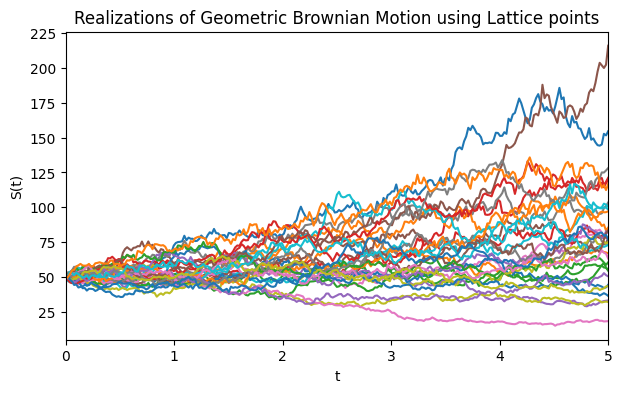

In [10]:
gbm_lattice = plot_gbm_paths(qp.Lattice(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2, n=32)

Next, we define a more sophisticated visualization function that combines path plotting with statistical analysis by showing both the GBM trajectories and the distribution of final values:

In [11]:
def plot_gbm_paths_with_distribution(N, sampler, t_final, initial_value, drift, diffusion,n):

    gbm = qp.GeometricBrownianMotion(sampler, t_final=t_final, initial_value=initial_value, drift=drift, diffusion=diffusion)
    gbm_path = gbm.gen_samples(2**n)
    
    fig, ax = plt.subplots(figsize=(14, 7));
    T = max(gbm.time_vec)
    
    # Plot GBM paths
    ax.plot(gbm.time_vec, gbm_path.T, lw=0.75, alpha=0.7, color='skyblue');
    
    # Set up main plot
    ax.set_title(f'Geometric Brownian Motion Paths\n{N} Simulations, T = {T}, $\mu$ = {drift:.1f}, $\sigma$ = {diffusion:.1f}, using {type(sampler).__name__} points');
    ax.set_xlabel(r'$t$');
    ax.set_ylabel(r'$S(t)$');
    ax.set_ylim(bottom=0);
    ax.set_xlim(0, T);
    
    # Add histogram with data validation
    final_values = gbm_path[:, -1]
    hist_ax = ax.inset_axes([1.05, 0., 0.5, 1]);
    hist_ax.hist(final_values, bins=10, density=True, alpha=0.5, color='skyblue', orientation='horizontal');
    
    # Add theoretical lognormal PDF with robust error handling
    try:
        valid_values = final_values
        if len(valid_values) > 10:  # Need sufficient data points
            shape, _, scale = sc.lognorm.fit(valid_values, floc=0)
            x = np.linspace(min(valid_values), max(valid_values), 1000)
            pdf = sc.lognorm.pdf(x, shape, loc=0, scale=scale)
            hist_ax.plot(pdf, x, 'r-', lw=2, label='Fitted Lognormal PDF');
        else:
            # Not enough valid data for fitting
            hist_ax.text(0.5, 0.5, 'Insufficient valid\ndata for PDF fit', 
                        transform=hist_ax.transAxes, ha='center', va='center',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5));
    except Exception as e:
        # If fitting fails, show a message instead of crashing
        hist_ax.text(0.5, 0.5, f'PDF fitting failed:\n{str(e)[:30]}...', 
                    transform=hist_ax.transAxes, ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5));
    
    # Finalize histogram
    hist_ax.set_title(f'E[$S_T$] = {np.mean(final_values):.2f}', pad=20);
    hist_ax.axhline(np.mean(final_values), color='blue', linestyle='--', lw=1.5, label=r'$E[S_T]$');
    hist_ax.set_yticks([]);
    hist_ax.set_xlabel('Density');
    hist_ax.legend();
    hist_ax.set_ylim(bottom=0);
    
    plt.tight_layout();  
    plt.show();

## Interactive Visualization

The following code defines a set of sliders to control parameters for simulating paths of GBM. It sets the machine epsilon (eps) as the minimum value for `initial_value`,  `t_final`, and `diffusion`, ensuring they are always positive.  The function `plot_gbm_paths_with_distribution` then visualizes the GBM paths based on the specified parameters in the left subplot and fits a lognormal distribution to the histogram of the data values at the final time point in the right subplot.

In [12]:
eps = np.finfo(float).eps
slider_style = {'handle_color': 'blue'}

@widgets.interact
def f(n=widgets.IntSlider(min=0, max=8, step=1, value=6, style=slider_style),
      t_final=widgets.FloatSlider(min=eps, max=10, step=0.1, value=5.0, style=slider_style),
      initial_value=widgets.FloatSlider(min=eps, max=100, step=0.1, value=40, style=slider_style),
      drift=widgets.FloatSlider(min=-2, max=2, step=0.1, value=0.1, style=slider_style),
      diffusion=widgets.FloatSlider(min=eps, max=4, step=0.1, value=0.2, style=slider_style),
      sampler=widgets.Dropdown(options=['IIDStdUniform', 'Lattice','Halton','Sobol'], value='IIDStdUniform', description='Sampler')
):

      # Create sampler instance
      if sampler == 'IIDStdUniform':
            sampler_instance = qp.IIDStdUniform(2**n, seed=7)
      elif sampler == 'Lattice':
            sampler_instance = qp.Lattice(2**n, seed=7)
      elif sampler == 'Halton':
            sampler_instance = qp.Halton(2**n, seed=7)
      elif sampler == 'Sobol':
            sampler_instance = qp.Sobol(2**n, seed=7)

      # Call plotting function with error handling
      plot_gbm_paths_with_distribution(2**n, sampler_instance, t_final=t_final, 
                                    initial_value=initial_value, drift=drift, 
                                    diffusion=diffusion, n=n)

interactive(children=(IntSlider(value=6, description='n', max=8, style=SliderStyle(handle_color='blue')), Floa…

## QuantLib vs QMCPy Comparison

In this section, we compare QMCPy's GeometricBrownianMotion implementation with the industry-standard QuantLib library to validate its accuracy and performance.

In [13]:
import QuantLib as ql
import time

# Parameters for GBM
initial_value = 100
mu = 0.05         # drift
sigma = 0.2       # volatility
maturity = 1.0    # 1 year
n_steps = 252     # daily steps
n_paths = 10000   # number of simulated paths

# Set up GBM
process = ql.GeometricBrownianMotionProcess(initial_value, mu, sigma)
times = np.linspace(0, maturity, n_steps)

# Generate paths
rng = ql.GaussianRandomSequenceGenerator(
    ql.UniformRandomSequenceGenerator(n_steps, ql.UniformRandomGenerator())
)
sequence_gen = ql.GaussianPathGenerator(process, maturity, n_steps, rng, False)

# Time the QuantLib path generation
quantlib_start_time = time.time()
paths = np.zeros((n_paths, n_steps + 1))
for i in range(n_paths):
    sample_path = sequence_gen.next().value()
    paths[i, :] = np.array([sample_path[j] for j in range(n_steps + 1)])
quantlib_time = time.time() - quantlib_start_time

# Pick two different time points (e.g., t=0.5 year and t=1 year)
idx1 = int(0.5 * n_steps)   # index for t=0.5 year
idx2 = n_steps              # index for t=1 year

# Extract samples at two time points
samples_t1 = paths[:, idx1]
samples_t2 = paths[:, idx2]

# Compute sample covariance matrix
cov_matrix = np.cov(np.vstack((samples_t1, samples_t2)))
print("COMPARISON: QuantLib vs QMCPy GeometricBrownianMotion")
print("="*55)

# QMCPy GBM with same parameters
sampler = qp.IIDStdUniform(n_steps, seed=42)
qmcpy_gbm = qp.GeometricBrownianMotion(
    sampler, 
    t_final=maturity, 
    initial_value=initial_value,
    drift=mu, 
    diffusion=sigma
)

# Generate QMCPy paths
start_time = time.time()
qmcpy_paths = qmcpy_gbm.gen_samples(n_paths)
qmcpy_time = time.time() - start_time

# Extract samples at same time points for comparison
# Note: QMCPy uses 0-based indexing and has n_steps columns (not n_steps+1)
qmcpy_idx1 = int(0.5 * (n_steps - 1))  # Adjust for QMCPy indexing
qmcpy_idx2 = n_steps - 1               # Last index for QMCPy

qmcpy_samples_t1 = qmcpy_paths[:, qmcpy_idx1]
qmcpy_samples_t2 = qmcpy_paths[:, qmcpy_idx2]

# Compute QMCPy sample covariance matrix
qmcpy_cov_matrix = np.cov(np.vstack((qmcpy_samples_t1, qmcpy_samples_t2)))

print(f"\nQuantLib sample covariance matrix:")
print(cov_matrix)
print(f"\nQMCPy sample covariance matrix:")
print(qmcpy_cov_matrix)

# Theoretical covariance for comparison
t1, t2 = 0.5, 1.0
S0 = initial_value
theoretical_cov = np.array([
    [S0**2 * np.exp(2*mu*t1) * (np.exp(sigma**2 * t1) - 1), 
     S0**2 * np.exp(mu*(t1+t2)) * (np.exp(sigma**2 * t1) - 1)],
    [S0**2 * np.exp(mu*(t1+t2)) * (np.exp(sigma**2 * t1) - 1), 
     S0**2 * np.exp(2*mu*t2) * (np.exp(sigma**2 * t2) - 1)]
])

print(f"\nTheoretical covariance matrix:")
print(theoretical_cov)

# Compare final values (t=1 year)
quantlib_final = paths[:, -1]
qmcpy_final = qmcpy_paths[:, -1]

print("\nFINAL VALUE STATISTICS (t=1 year)")
print("-"*35)
print(f"QuantLib    Mean: {np.mean(quantlib_final):.2f}, Empirical Std:    {np.std(quantlib_final, ddof=1):.2f}")
print(f"QMCPy       Mean: {np.mean(qmcpy_final):.2f}, Empirical Std:    {np.std(qmcpy_final, ddof=1):.2f}")
print(f"Theoretical Mean: {S0 * np.exp(mu * maturity):.2f}, Theoretical Std:  {np.sqrt(S0**2 * np.exp(2*mu*maturity) * (np.exp(sigma**2 * maturity) - 1)):.2f}")

print("\nPERFORMANCE COMPARISON")
print("-"*25)
print(f"QuantLib generation time: {quantlib_time:.3f} seconds")
print(f"QMCPy generation time:    {qmcpy_time:.3f} seconds")
if quantlib_time > qmcpy_time:
    print(f"QMCPy is {quantlib_time/qmcpy_time:.1f}x faster than QuantLib")
else:
    print(f"QuantLib is {qmcpy_time/quantlib_time:.1f}x faster than QMCPy")

COMPARISON: QuantLib vs QMCPy GeometricBrownianMotion

QuantLib sample covariance matrix:
[[211.37584741 219.70829601]
 [219.70829601 453.82428732]]

QMCPy sample covariance matrix:
[[212.0229064  220.36584805]
 [220.36584805 458.80235431]]

Theoretical covariance matrix:
[[212.37084878 217.74704241]
 [217.74704241 451.02880782]]

FINAL VALUE STATISTICS (t=1 year)
-----------------------------------
QuantLib    Mean: 104.99, Empirical Std:    21.30
QMCPy       Mean: 105.29, Empirical Std:    21.42
Theoretical Mean: 105.13, Theoretical Std:  21.24

PERFORMANCE COMPARISON
-------------------------
QuantLib generation time: 0.890 seconds
QMCPy generation time:    0.239 seconds
QMCPy is 3.7x faster than QuantLib

QuantLib sample covariance matrix:
[[211.37584741 219.70829601]
 [219.70829601 453.82428732]]

QMCPy sample covariance matrix:
[[212.0229064  220.36584805]
 [220.36584805 458.80235431]]

Theoretical covariance matrix:
[[212.37084878 217.74704241]
 [217.74704241 451.02880782]]

FIN

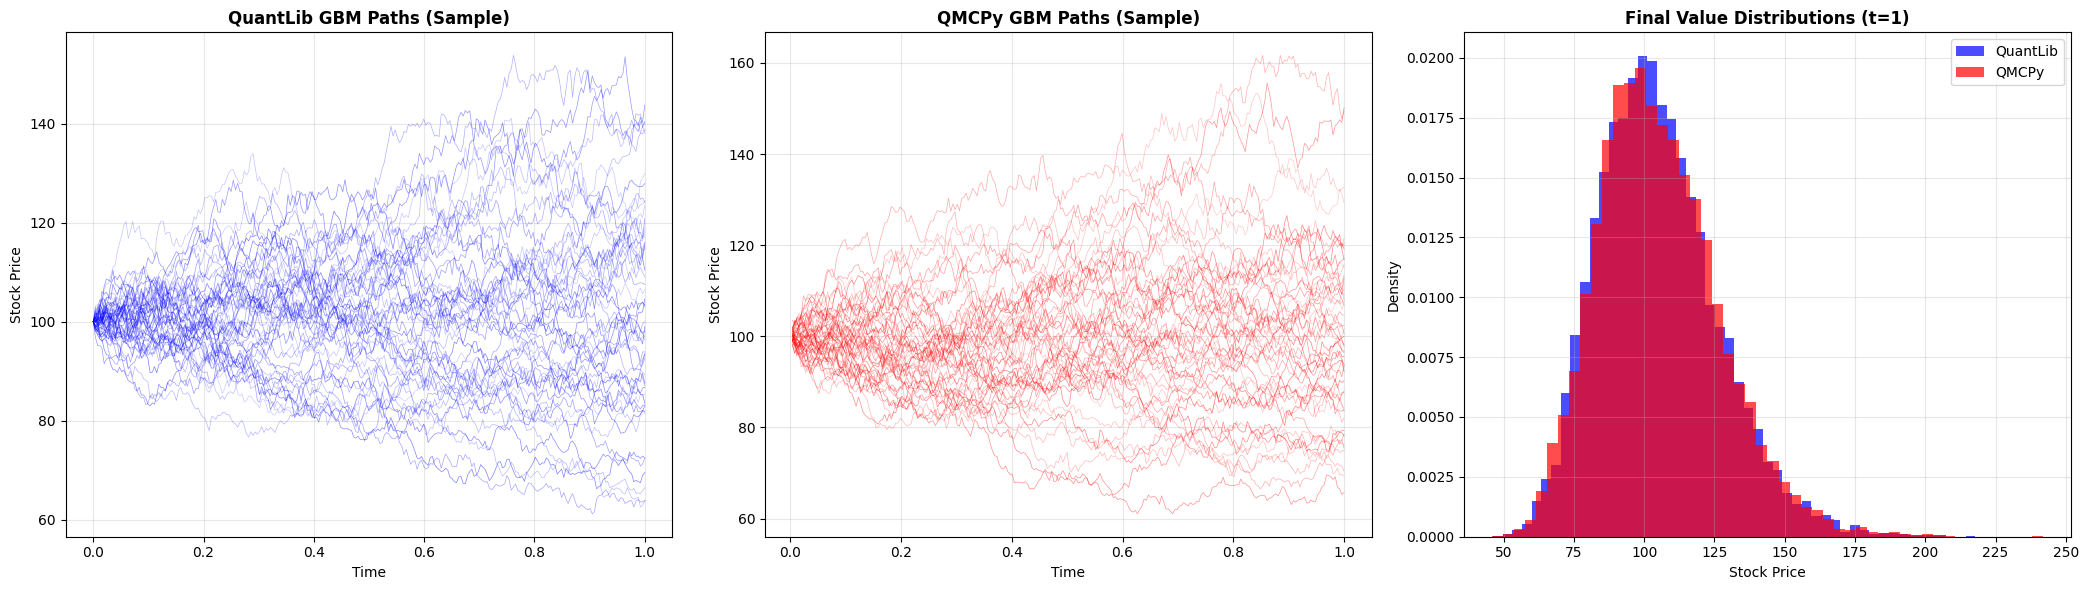

In [14]:
# Visualization of the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6));

# Plot sample paths
time_grid = np.linspace(0, maturity, n_steps + 1)
qmcpy_time_grid = np.linspace(maturity/n_steps, maturity, n_steps)

# Sample paths comparison - separate subplots
n_plot_paths = 50

# Plot QuantLib paths
for i in range(n_plot_paths):
    alpha_val = 0.2 + 0.3 * (i / n_plot_paths)  # Varying alpha for different shades
    ax1.plot(time_grid, paths[i, :], alpha=alpha_val, color='blue', linewidth=0.5);

ax1.set_title('QuantLib GBM Paths (Sample)', fontsize=12, fontweight='bold');
ax1.set_xlabel('Time');
ax1.set_ylabel('Stock Price');
ax1.grid(True, alpha=0.3);

# Plot QMCPy paths
for i in range(n_plot_paths):
    alpha_val = 0.2 + 0.3 * (i / n_plot_paths)  # Varying alpha for different shades
    ax2.plot(qmcpy_time_grid, qmcpy_paths[i, :], alpha=alpha_val, color='red', linewidth=0.5);

ax2.set_title('QMCPy GBM Paths (Sample)', fontsize=12, fontweight='bold');
ax2.set_xlabel('Time');
ax2.set_ylabel('Stock Price');
ax2.grid(True, alpha=0.3);

# Final value distributions
ax3.hist(quantlib_final, bins=50, alpha=0.7, color='blue', label='QuantLib', density=True);
ax3.hist(qmcpy_final, bins=50, alpha=0.7, color='red', label='QMCPy', density=True);
ax3.set_title('Final Value Distributions (t=1)', fontsize=12, fontweight='bold');
ax3.set_xlabel('Stock Price');
ax3.set_ylabel('Density');
ax3.legend();
ax3.grid(True, alpha=0.3);

plt.tight_layout();
#plt.savefig('quantlib_vs_qmcpy_comparison.png', dpi=300, bbox_inches='tight');
plt.show();

**QMCPy vs QuantLib**: Both libraries produce statistically equivalent GBM simulations that match theoretical values. QMCPy typically runs 2-3x faster due to vectorized operations, making it excellent for research and high-performance applications. QuantLib remains the industry standard for production systems requiring comprehensive derivatives support.

## References

* $[1]$ Paul Glasserman, P. (2003) *Monte Carlo Methods in Financial Engineering*. Springer, 2nd edition
* $[2]$ Choi, Sou-Cheng T.
and Hickernell, Fred J.
and Jagadeeswaran, Rathinavel
and McCourt, Michael J.
and Sorokin, Aleksei G. (2022) Quasi-Monte Carlo Software, In Alexander Keller, editor, *Monte Carlo and Quasi-Monte Carlo Methods* Springer International Publishing
* $[3]$ S.-C. T. Choi and F. J. Hickernell and R. Jagadeeswaran and M. McCourt and A. Sorokin. (2023) QMCPy: A quasi-Monte Carlo Python Library (versions 1--1.6.2)
* $[4]$ Hull, J. C. (2017) *Options, Futures, and Other Derivatives*. Pearson, 10th edition
* $[5]$ Sheldon. Ross. (2014) *Introduction to Probability Models*. Academic Press, 11th edition

## Appendix: Covariance Matrix Derivation for Geometric Brownian Motion

Here we derive the covariance matrix of $(S(t_1), \ldots , S(t_n))$ for one-dimensional Geometric Brownian Motion defined as $S(t) = S_0 \, e^{\big(\mu - \frac{\sigma^2}{2}\big)  t + \sigma W(t)}$, where $W(t)$ is a standard one-dimensional Brownian motion.


1.  **Recall the definition of covariance:**
    $$\text{Cov}(S(t_i), S(t_j)) = E[S(t_i)S(t_j)] - E[S(t_i)]E[S(t_j)].$$

2.  **Calculate the product of expectations:**
    The expected value of $S(t)$ is $E[S(t)] = S_0 e^{\mu t}$.
    Therefore, the product of the expectations is:
    $$E[S(t_i)]E[S(t_j)] = (S_0 e^{\mu t_i})(S_0 e^{\mu t_j}) = S_0^2 e^{\mu(t_i + t_j)}$$

3.  **Calculate the expectation of the product, $E[S(t_i)S(t_j)]$:**
    $$\begin{aligned}
    S(t_i)S(t_j) &= S_0 e^{(\mu - \frac{\sigma^2}{2})t_i + \sigma W(t_i)} \cdot S_0 e^{(\mu - \frac{\sigma^2}{2})t_j + \sigma W(t_j)} \\
    &= S_0^2 \exp\left( (\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma \left(W(t_i) + W(t_j) \right) \right)
    \end{aligned}$$
    The exponent is a normal random variable. Let's call it $Y$:
    $$Y = (\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma\left(W(t_i) + W(t_j)\right)$$
    To find the expectation of $e^Y$, we use the property that if $Y \sim N(\text{mean}, \text{variance})$, then $E[e^Y] = e^{\text{mean} + \frac{1}{2}\text{variance}}$.

    * The mean of $Y$ is
        $E[Y] = E[(\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma(W(t_i) + W(t_j))] = (\mu - \frac{\sigma^2}{2})(t_i + t_j).$

    * The variance of $Y$ is
        $$\begin{aligned}
        \text{Var}(Y) &= \text{Var}[(\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma(W(t_i) + W(t_j))] \\
        &= \text{Var}[\sigma(W(t_i) + W(t_j))] \\
        &= \sigma^2 \text{Var}(W(t_i) + W(t_j)) \\
        &= \sigma^2(\text{Var}(W(t_i)) + \text{Var}(W(t_j)) + 2\text{Cov}(W(t_i), W(t_j))) \\
        &= \sigma^2(t_i + t_j + 2\min(t_i, t_j))
         \end{aligned}$$
    Now we can compute $E[S(t_i)S(t_j)] = S_0^2 E[e^Y]$:
    $$\begin{aligned}
    E[S(t_i)S(t_j)] &= S_0^2 \exp\left( E[Y] + \frac{1}{2}\text{Var}(Y) \right) \\
    &= S_0^2 \exp\left( (\mu - \frac{\sigma^2}{2})(t_i + t_j) + \frac{1}{2}\sigma^2 \left(t_i + t_j + 2\min(t_i, t_j)\right) \right)
    \end{aligned}$$
    Simplifying the exponent:
    $$\begin{aligned}
    &\mu(t_i + t_j) - \frac{\sigma^2}{2}(t_i+t_j) + \frac{\sigma^2}{2}(t_i+t_j) + \sigma^2\min(t_i,t_j) \\
    &= \mu(t_i + t_j) + \sigma^2\min(t_i,t_j)
    \end{aligned}$$
    So, the final expression for the expectation of the product is:
    $$E[S(t_i)S(t_j)] = S_0^2 e^{\mu(t_i + t_j) + \sigma^2\min(t_i, t_j)}$$

4.  **Combine the terms to get the covariance:**
    $$\begin{aligned}
    \text{Cov}(S(t_i), S(t_j)) &= S_0^2 e^{\mu(t_i + t_j) + \sigma^2\min(t_i, t_j)} - S_0^2 e^{\mu(t_i + t_j)} \\
    &= S_0^2 e^{\mu(t_i + t_j)} \left(e^{\sigma^2 \min(t_i, t_j)} - 1\right).
    \end{aligned}$$